In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings

In [23]:
df=pd.read_csv('data/flight.csv')
df.head()

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [24]:
x=df.drop(columns=['price','flight','Unnamed: 0'],axis=1)
x.head()

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left
0,SpiceJet,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1
1,SpiceJet,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1
2,AirAsia,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1
3,Vistara,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1
4,Vistara,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1


In [25]:
y=df['price']
y.head()

0    5953
1    5953
2    5956
3    5955
4    5955
Name: price, dtype: int64

In [26]:
num_features=x.select_dtypes(exclude='object').columns
cat_features=x.select_dtypes(include='object').columns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numeric_transformer=StandardScaler()
oh_transformer=OneHotEncoder()

preprocessor=ColumnTransformer(
    [
        ("OneHotEncoder",oh_transformer,cat_features),
        ("StandardScaler",numeric_transformer,num_features)
    ]
)

In [27]:
x=preprocessor.fit_transform(x)
x

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2701377 stored elements and shape (300153, 37)>

In [28]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)
x_train.shape, x_test.shape

((240122, 37), (60031, 37))

In [29]:
def evaluate_model (true, predicted):
    mae=mean_absolute_error(true,predicted)
    mse=mean_squared_error(true,predicted)
    rmse=np.sqrt(mean_squared_error(true,predicted))
    r2_square=r2_score(true,predicted)
    return mae, rmse, r2_square

In [30]:
models={
    "LinearRegression" : LinearRegression(),
    "Lasso": Lasso(),
    "Ridge" : Ridge(),
    "Decision Tree": DecisionTreeRegressor(max_depth=15),
    "Random Forest": RandomForestRegressor(n_estimators=50, max_depth=15, n_jobs=-1),
    "XGBRegressor": XGBRegressor(n_estimators=50, max_depth=8, n_jobs=-1),
    "CatBoost": CatBoostRegressor(iterations=100, depth=8, verbose=False),
    "AdaBoost": AdaBoostRegressor(n_estimators=50)
}
model_list= []
r2_list=[]

for i in range(len(list(models))):
    model=list(models.values())[i]
    model.fit(x_train, y_train)

    y_train_pred= model.predict(x_train)
    y_test_pred=model.predict(x_test)

    model_train_mae, model_train_rmse, model_train_r2= evaluate_model(y_train, y_train_pred)
    model_test_mae, model_test_rmse, model_test_r2= evaluate_model(y_test,y_test_pred) 

    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])

    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    
    print('='*35)

LinearRegression
Model performance for Training set
- Root Mean Squared Error: 6752.1353
- Mean Absolute Error: 4573.9849
- R2 Score: 0.9115
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 6761.7134
- Mean Absolute Error: 4553.2881
- R2 Score: 0.9113
Lasso
Model performance for Training set
- Root Mean Squared Error: 6752.1757
- Mean Absolute Error: 4572.1745
- R2 Score: 0.9115
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 6761.7995
- Mean Absolute Error: 4551.5770
- R2 Score: 0.9113
Ridge
Model performance for Training set
- Root Mean Squared Error: 6752.1357
- Mean Absolute Error: 4573.9078
- R2 Score: 0.9115
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 6761.7191
- Mean Absolute Error: 4553.2245
- R2 Score: 0.9113
Decision Tree
Model performance for Training set
- Root Mean Squared Error: 3332.2607
- Mean Absolute Error: 1683.0820
- R2 Score: 0.9

In [31]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name','R2_Score']).sort_values(by=['R2_Score'],ascending=False)

,Model Name,R2_Score
5,XGBRegressor,0.981107
6,CatBoost,0.977847
4,Random Forest,0.976952
3,Decision Tree,0.971969
7,AdaBoost,0.933727
0,LinearRegression,0.911305
2,Ridge,0.911305
1,Lasso,0.911303


In [33]:
xgb_model=XGBRegressor()
xgb_model=xgb_model.fit(x_train,y_train)
y_pred=xgb_model.predict(x_test)
score=r2_score(y_test,y_pred)*100
print("Accuracy of the model is %.2f" %score)

Accuracy of the model is 97.66


Text(0, 0.5, 'Predicted')

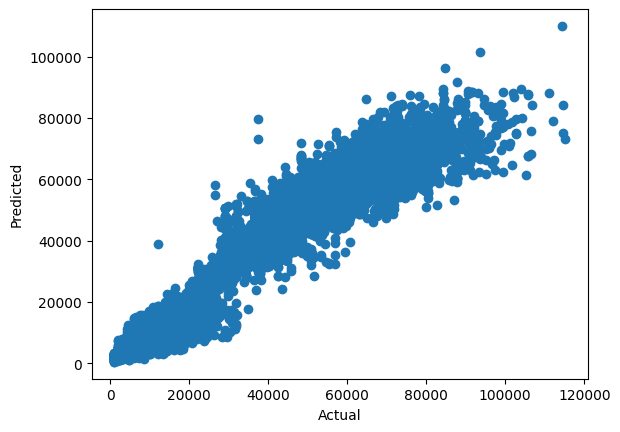

In [34]:
plt.scatter(y_test,y_pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")

/Users/hanan/Documents/flight_price_predictor/flight_env/lib/python3.10/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/Users/hanan/Documents/flight_price_predictor/flight_env/lib/python3.10/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/Users/hanan/Documents/flight_price_predictor/flight_env/lib/python3.10/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: invalid value encountered in matmul
  return _core_matmul(x1, x2)


<Axes: xlabel='price'>

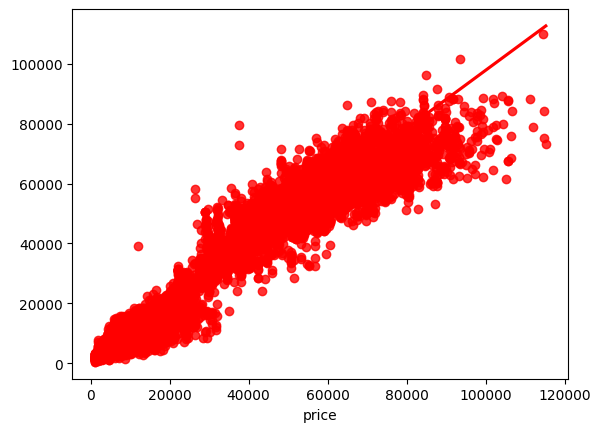

In [35]:
sns.regplot(x=y_test,y=y_pred,ci=None,color='red')

In [36]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred, 'Difference':y_test-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
27131,7366,6831.784180,534.215820
266857,64831,68877.304688,-4046.304688
141228,6195,5593.086426,601.913574
288329,60160,57949.714844,2210.285156
97334,6578,6018.442383,559.557617
...,...,...,...
5234,5026,5277.875488,-251.875488
5591,3001,2838.524170,162.475830
168314,6734,6968.826172,-234.826172
175191,5082,3862.193359,1219.806641
